In [ ]:
# 코랩 연걸
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
datapath_st = '/content/drive/MyDrive/공모전/data/한국지능정보사회진흥원_2021년 사이버폭력 실태조사 통계자료(학생)_20211231.csv'
data = pd.read_csv(datapath_st, encoding = 'cp949')


<ipython-input-3-30bf67123cfa>:2: DtypeWarning: Columns (95) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datapath_st, encoding = 'cp949')


In [ ]:
# data['violence_exp'] = data.apply(lambda x : 1 if pd.notnull(x['Q9_1']) else 0, axis = 1)
# data['violence_exp'].value_counts()

In [ ]:
# #사용할 컬럼들로 데이터 프레임 구성하기 -> cols_add_Q10에서 Q10 그냥 뺌...
# with open('/content/drive/MyDrive/공모전/cols_add_Q10.txt','r') as f:
#     cols = [line.strip() for line in f.readlines()]
# df = data[cols]
# df.head()

# 1. 데이터 전처리

In [ ]:
pd.set_option('display.max_columns',None)   #모든열출력
pd.set_option('display.max_rows',None)      #모든행출력

In [ ]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
#data에 데이터 불러온 후 가해학생 컬럼 생성
data['violence_exp'] = data.apply(lambda x : 1 if pd.notnull(x['Q9_1']) else 0, axis = 1)

#사용할 컬럼들로 데이터 프레임 구성하기 -> cols_add_Q10에서 Q10 그냥 뺌...
with open('/content/drive/MyDrive/공모전/cols_add_Q10.txt','r') as f:
    cols = [line.strip() for line in f.readlines()]
df = data[cols]
df.head()

# 영어로 변수명 변경
rename_cols = {
    '시도' : 'city',
    '행정구' : 'district',
    '학교급' : 'school_level',
    '학교세부유형' : 'school_type',
    '남녀공학구분' : 'is_coed',
    '지역규모' : 'area_scale',
}
df.rename(columns = rename_cols, inplace = True)


<ipython-input-6-98a78c11a323>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = rename_cols, inplace = True)


In [ ]:
print(df.columns)

Index(['city', 'district', 'school_level', 'school_type', 'is_coed',
       'area_scale', 'SQ5', 'Q1', 'Q2_1', 'Q3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4',
       'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5',
       'Q6_1a', 'Q7', 'Q11_1', 'Q11_2', 'Q11_3', 'Q12_1', 'Q12_2', 'Q12_3',
       'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q14_1', 'Q14_2', 'Q14_3',
       'Q14_4', 'Q14_5', 'Q14_6', 'Q15', 'Q16', 'Q17', 'Q18_1', 'Q18_2',
       'Q18_3', 'Q19_1', 'Q19_2', 'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6', 'Q20_1',
       'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4',
       'Q21_5', 'Q22_1', 'Q23_1', 'Q24', 'A_1', 'A_2', 'A_3', 'A_4', 'A_5',
       'A_6', 'A_7', 'A_8', 'B_1', 'B_2', 'C', 'D', 'violence_exp'],
      dtype='object')


In [ ]:

# 데이터 전처리 for catboost
def preprocess (df):    
    target = 'violence_exp'
    df_p = df.copy()

    # 종속성 있는 + 불필요한 변수 제거
    drop_cols = ['Q6_1a', 'A_7', 'A_8', 'Q13_5', 'Q14_6', 'A_3','A_4'] 
    df_p = df_p.drop(drop_cols, axis=1)
    
    # 남녀공학 결측치 처리
    df_p['is_coed'] = df_p['is_coed'].fillna('남여공학')
    
    #Q13_1~4 , Q14_1~5, A_1~6 -> 결측치는 모두 0으로 처리
    cols_to_fillna = ['Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 
                      'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 
                      'A_1', 'A_2', 'A_5', 'A_6']
    for col in cols_to_fillna:
        df_p[col] = df_p[col].fillna(0)

    # 9->0, 99->0
    cols_to_change = ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5',
                      'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5',
                      'B_1', 'B_2']
    df_p[cols_to_change] = df_p[cols_to_change].applymap(lambda x : 0 if (x == 9) or (x==99) else x)
    
    # X,Y분리
    y = df_p[target]
    X = df_p.drop(target,axis=1)
    print(X.shape, y.shape)

    # 라벨인코딩
    le_cols = ['city', 'district','school_level',	 'school_type',	'is_coed',	'area_scale'] 
    le = LabelEncoder()
    for col in le_cols :
        X[col] = le.fit_transform(X[col])
        print(col, le.classes_)
    
    X = X.astype(int) # Catboost에서는 실수 인식 x. 정수형으로 바꿔주자
    return df_p, X, y


In [ ]:
# 데이터 전처리 범주 재설정 한 버전
def preprocess_reset_category(df):    
    target = 'violence_exp'
    df_p = df.copy()
    ####################### 결측치 및 불필요한 변수 처리 ########################
    # 종속성 있는 + 불필요한 변수 제거
    drop_cols = ['Q6_1a', 'A_7', 'A_8', 'Q13_5', 'Q14_6', 'A_3','A_4'] 
    df_p = df_p.drop(drop_cols, axis=1)
    
    # 남녀공학 결측치 처리
    df_p['is_coed'] = df_p['is_coed'].fillna('남여공학')
    
    #Q13_1~4 , Q14_1~5 -> 결측치는 모두 0으로 처리
    cols_to_fillna = ['Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'A_1', 'A_2', 'A_5', 'A_6']
    for col in cols_to_fillna:
        df_p[col] = df_p[col].fillna(0)

    # 9->0, 99->0
    cols_to_change = ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5', 'B_1', 'B_2']
    df_p[cols_to_change] = df_p[cols_to_change].applymap(lambda x : 0 if (x == 9) or (x==99) else x)
    
    ########################## 범주값 재설정 ############################
    # 사이버인식조사 -> 문제안됨(1), 문제됨(2)
    cols = ['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4', 'Q21_5']
    map_dict = {1:1, 2:1, 3:2, 4:2}
    for col in cols:
        df_p[col] = df_p[col].map(map_dict)
    
    # 유해 컨텐츠 노출 정도 & 사이버 범죄 목격경험 ->  {0:'전혀없음', 1: '가끔', 2: '자주'}
    cols = ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5']
    map_dict = {0:0, 1:1, 2:1, 3:2, 4:2, 5:2}
    for col in cols:
        df_p[col] = df_p[col].map(map_dict)

    #친구/부모와의 관계 & 인터넷 정보확인 활동/안전 활동 {1: '그렇지 않다', 2: '그렇다'}
    cols = [ 'Q11_1', 'Q11_2', 'Q11_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q18_1', 'Q18_2', 'Q18_3', 'Q19_1', 'Q19_2', 'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6']
    map_dict = {1:1, 2:1, 3:2, 4:2}
    for col in cols:
        df_p[col] = df_p[col].map(map_dict)

    # X,Y분리
    y = df_p[target]
    X = df_p.drop(target,axis=1)
    print(X.shape, y.shape)

    # 라벨인코딩
    le_cols = ['city', 'district',	'school_level',	 'school_type',	'is_coed',	'area_scale'] 
    le = LabelEncoder()
    for col in le_cols :
        X[col] = le.fit_transform(X[col])
    
    X = X.astype(int) # Catboost에서는 실수 인식 x. 정수형으로 바꿔주자
    return df_p, X, y

In [ ]:
df_p,X,y = preprocess(df)

(9017, 72) (9017,)
city ['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
district ['강남구' '강동구' '강릉시' '강북구' '강서구' '거제시' '거창군' '경산시' '경주시' '계룡시' '계양구' '고양시'
 '관악구' '광명시' '광산구' '광양시' '광주시' '광진구' '구로구' '구리시' '구미시' '군산시' '군포시' '금정구'
 '금천구' '기장군' '김천시' '김포시' '김해시' '나주시' '남구' '남동구' '남양주시' '남원시' '노원구' '논산시'
 '달서구' '달성군' '당진시' '대덕구' '도봉구' '동구' '동대문구' '동래구' '동작구' '동해시' '마포구' '목포시'
 '무안군' '미추홀구' '보령시' '보성군' '부산진구' '부안군' '부천시' '부평구' '북구' '사상구' '사천시' '사하구'
 '삼척시' '상주시' '서구' '서귀포시' '서대문구' '서초구' '성남시' '성동구' '성북구' '세종시' '속초시' '송파구'
 '수성구' '수영구' '수원시' '순천시' '아산시' '안동시' '안성시' '안양시' '양산시' '양천구' '양평군' '여수시'
 '연수구' '연제구' '영도구' '영주시' '예산군' '오산시' '완도군' '용인시' '울주군' '원주시' '유성구' '은평구'
 '음성군' '의정부시' '이천시' '익산시' '장수군' '전주시' '제주시' '제천시' '중구' '중랑구' '진주시' '진천군'
 '창녕군' '창원시' '천안시' '청주시' '춘천시' '충주시' '태안군' '통영시' '파주시' '평택시' '포항시' '하남시'
 '해운대구' '홍성군' '화성시']
school_level ['고등학교' '중학교' '초등학교']
school_type ['가사고등학교' '공업고등학교' '농림업고등학교' '상업고등학교' '실업고등학교' '외국어고등학교' '일반고등학교' '일반중학교'
 '종합고

In [ ]:
# X.to_csv('/content/drive/MyDrive/공모전/data/data_x.csv')
# yyy.to_csv('/content/drive/MyDrive/공모전/data/data_y.csv')

In [ ]:
# train, test 분리 , 가변수화 안한 데이터 ->for catboost
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1, stratify = y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7213, 72) (1804, 72) (7213,) (1804,)


In [ ]:
x_train.columns

Index(['city', 'district', 'school_level', 'school_type', 'is_coed',
       'area_scale', 'SQ5', 'Q1', 'Q2_1', 'Q3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4',
       'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5',
       'Q7', 'Q11_1', 'Q11_2', 'Q11_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q13_1',
       'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5',
       'Q15', 'Q16', 'Q17', 'Q18_1', 'Q18_2', 'Q18_3', 'Q19_1', 'Q19_2',
       'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4',
       'Q20_5', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4', 'Q21_5', 'Q22_1', 'Q23_1',
       'Q24', 'A_1', 'A_2', 'A_5', 'A_6', 'B_1', 'B_2', 'C', 'D'],
      dtype='object')

In [ ]:
norminal_cols = ['city', 'district', 'school_level', 'school_type', 'is_coed', 'area_scale', 'SQ5', 'Q2_1' ,'Q7',  'Q13_1',
                 'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q15', 'Q16', 'Q17', 'Q22_1', 
                 'Q23_1', 'Q24',  'A_1', 'A_2', 'A_5', 'A_6', 'B_1', 'B_2']

# 3. Catboost 모델링 (명목형 변수만 범주형 처리) -> X

In [ ]:
target = 'violence_exp'

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(8,6))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df


In [ ]:
# 상위 n / 하위 n 변수 모자이크플롯그리기
import scipy.stats as spst
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

def calculate_chi2(data, n_features):
    chi2_result = pd.DataFrame(columns=['feature_name', 'chi2_val', 'p_value', 'dof', 'is_correlated'])
    
    for feature in n_features:
        table = pd.crosstab(data[feature], data[target])
        chi2_val, p_value, dof, _ = spst.chi2_contingency(table)
        corr = 'o' if chi2_val > 2 * dof else 'x'
        
        #행추가
        chi2_result = chi2_result.append({'feature_name': feature, 'chi2_val': chi2_val, 'p_value': p_value, 'dof': dof, 'is_correlated': corr}, ignore_index=True)
    
    return chi2_result

def draw_mosaic(data, n_features):
    for feature in n_features['feature_names']:
        plt.figure(figsize=(5, 4))
        mosaic(data, [feature, target], title=f'Mosaic plot for {feature}')
        plt.show()

def draw_stackedbar(data,n_features):
    for feature in n_features:
        plt.figure(figsize = (4,3))
        temp = pd.crosstab(index = data[feature], columns = data[target], normalize = 'index')
        temp.plot(kind = 'bar', stacked = True,grid = True)
        plt.legend(loc = 'lower left')
        plt.axhline(1 - data[target].mean(), color = 'r')
        plt.title(f'Stacked Bar Plot for {feature}')
        plt.show()

In [ ]:
#warning 무시 -> 안하면 엄청 머 뜸
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

all_cols = list(X)
print(all_cols)

['city', 'district', 'school_level', 'school_type', 'is_coed', 'area_scale', 'SQ5', 'Q1', 'Q2_1', 'Q3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q7', 'Q11_1', 'Q11_2', 'Q11_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q15', 'Q16', 'Q17', 'Q18_1', 'Q18_2', 'Q18_3', 'Q19_1', 'Q19_2', 'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4', 'Q21_5', 'Q22_1', 'Q23_1', 'Q24', 'A_1', 'A_2', 'A_5', 'A_6', 'B_1', 'B_2', 'C', 'D']


In [ ]:
# 모델링

model_1 = CatBoostClassifier(cat_features = all_cols, auto_class_weights = 'Balanced', verbose=0, random_state = 1)
model_1.fit(x_train, y_train)

KeyboardInterrupt: ignored

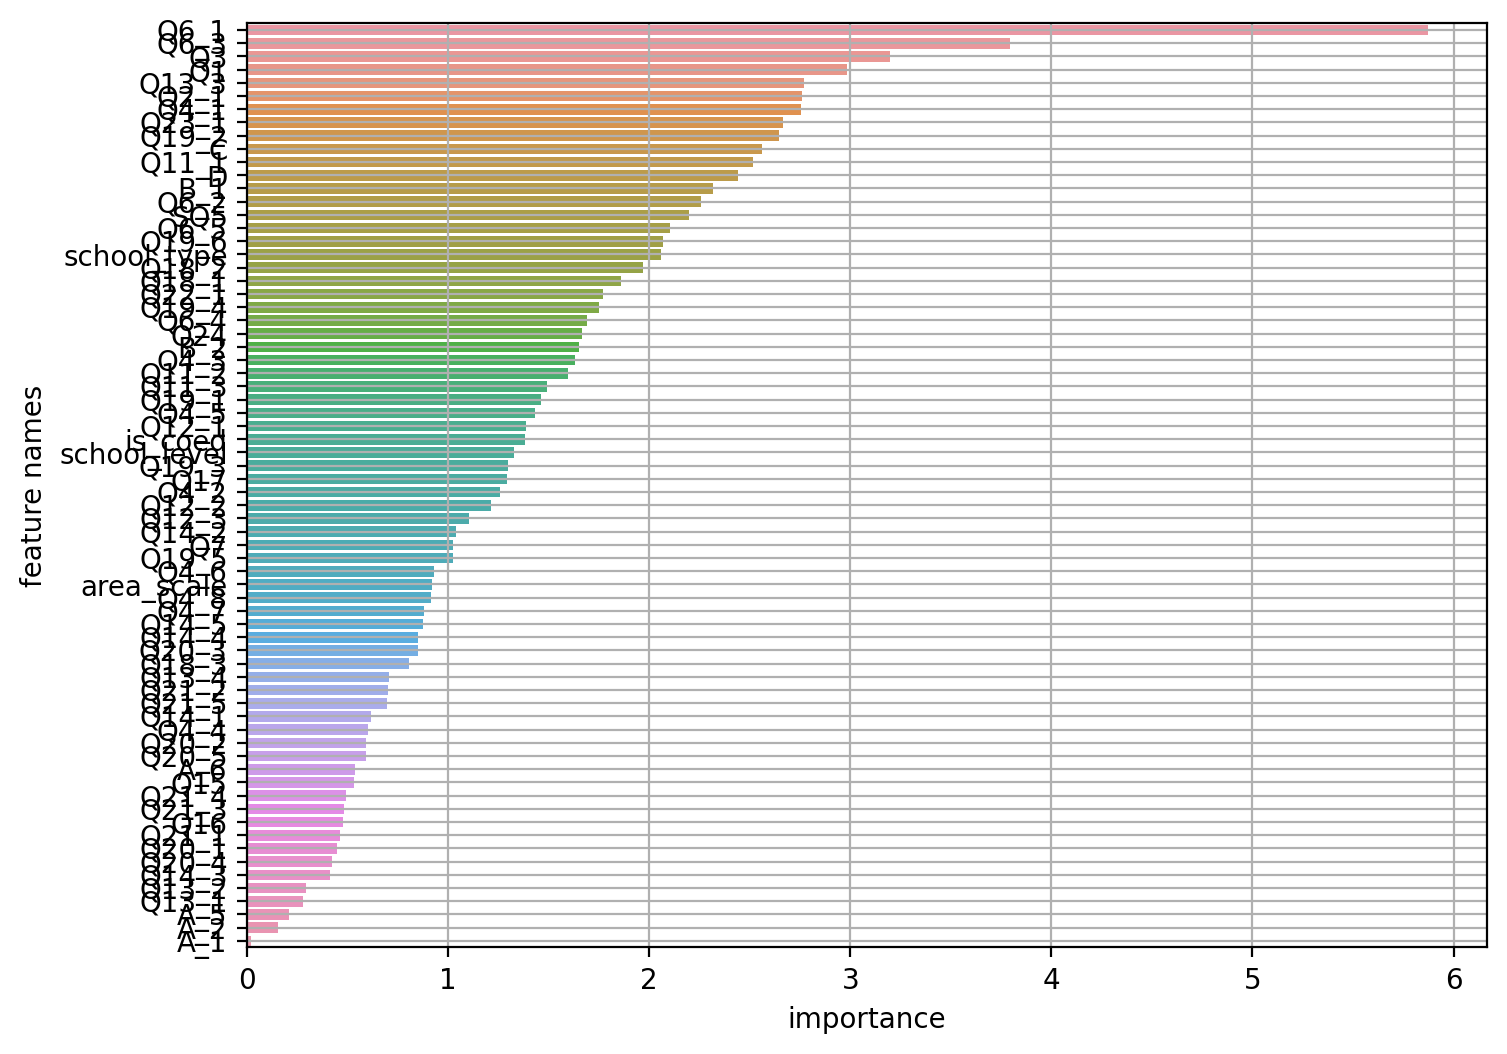

In [ ]:
result = plot_feature_importance(model_1.feature_importances_, list(x_train))

In [ ]:
# 성능테스트
y_pred = model_1.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1557
           1       0.42      0.64      0.51       247

    accuracy                           0.83      1804
   macro avg       0.68      0.75      0.70      1804
weighted avg       0.87      0.83      0.84      1804

[[1337  220]
 [  89  158]]


In [ ]:
# 범주 재설정한 데이터로 모델링 돌려보기
df_p,X,y = preprocess_reset_category(df) 

(9017, 72) (9017,)


In [ ]:
# train, test 분리 , 가변수화 안한 데이터 ->for catboost
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1, stratify = y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7213, 72) (1804, 72) (7213,) (1804,)


In [ ]:
# 모델링

model_2 = CatBoostClassifier(cat_features = all_cols, auto_class_weights = 'Balanced', verbose=0,random_state=1)
model_2.fit(x_train, y_train)

In [ ]:
# 성능테스트
y_pred = model_2.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1557
           1       0.38      0.56      0.45       247

    accuracy                           0.81      1804
   macro avg       0.65      0.71      0.67      1804
weighted avg       0.85      0.81      0.83      1804

[[1327  230]
 [ 108  139]]


# 4. 1번모델에 SMOTENC 샘플링 적용 후 모델링 ->변수중요도 신뢰성 떨어지는듯

In [ ]:
X.shape, y.shape

((9017, 72), (9017,))

In [ ]:
y.value_counts()

0    7781
1    1236
Name: violence_exp, dtype: int64

In [ ]:
X.columns

Index(['city', 'district', 'school_level', 'school_type', 'is_coed',
       'area_scale', 'SQ5', 'Q1', 'Q2_1', 'Q3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4',
       'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5',
       'Q7', 'Q11_1', 'Q11_2', 'Q11_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q13_1',
       'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5',
       'Q15', 'Q16', 'Q17', 'Q18_1', 'Q18_2', 'Q18_3', 'Q19_1', 'Q19_2',
       'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4',
       'Q20_5', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4', 'Q21_5', 'Q22_1', 'Q23_1',
       'Q24', 'A_1', 'A_2', 'A_5', 'A_6', 'B_1', 'B_2', 'C', 'D'],
      dtype='object')

In [ ]:
from imblearn.over_sampling import SMOTENC, SMOTE
norminal_indices = [X.columns.get_loc(col) for col in norminal_cols]

smote = SMOTENC(categorical_features= norminal_indices,sampling_strategy=0.5)   #categorical_features에는 열 인덱스 명시해줘야함
# smote = SMOTE(sampling_strategy='auto', random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)
x_smote.shape, y_smote.shape

((9336, 72), (9336,))

In [ ]:
y_smote.value_counts()

0    6224
1    3112
Name: violence_exp, dtype: int64

In [ ]:
# 모델링
resampled_model = CatBoostClassifier(cat_features = all_cols, verbose = 0) # 명목형 범주형변수로 간주
resampled_model.fit(x_smote, y_smote)

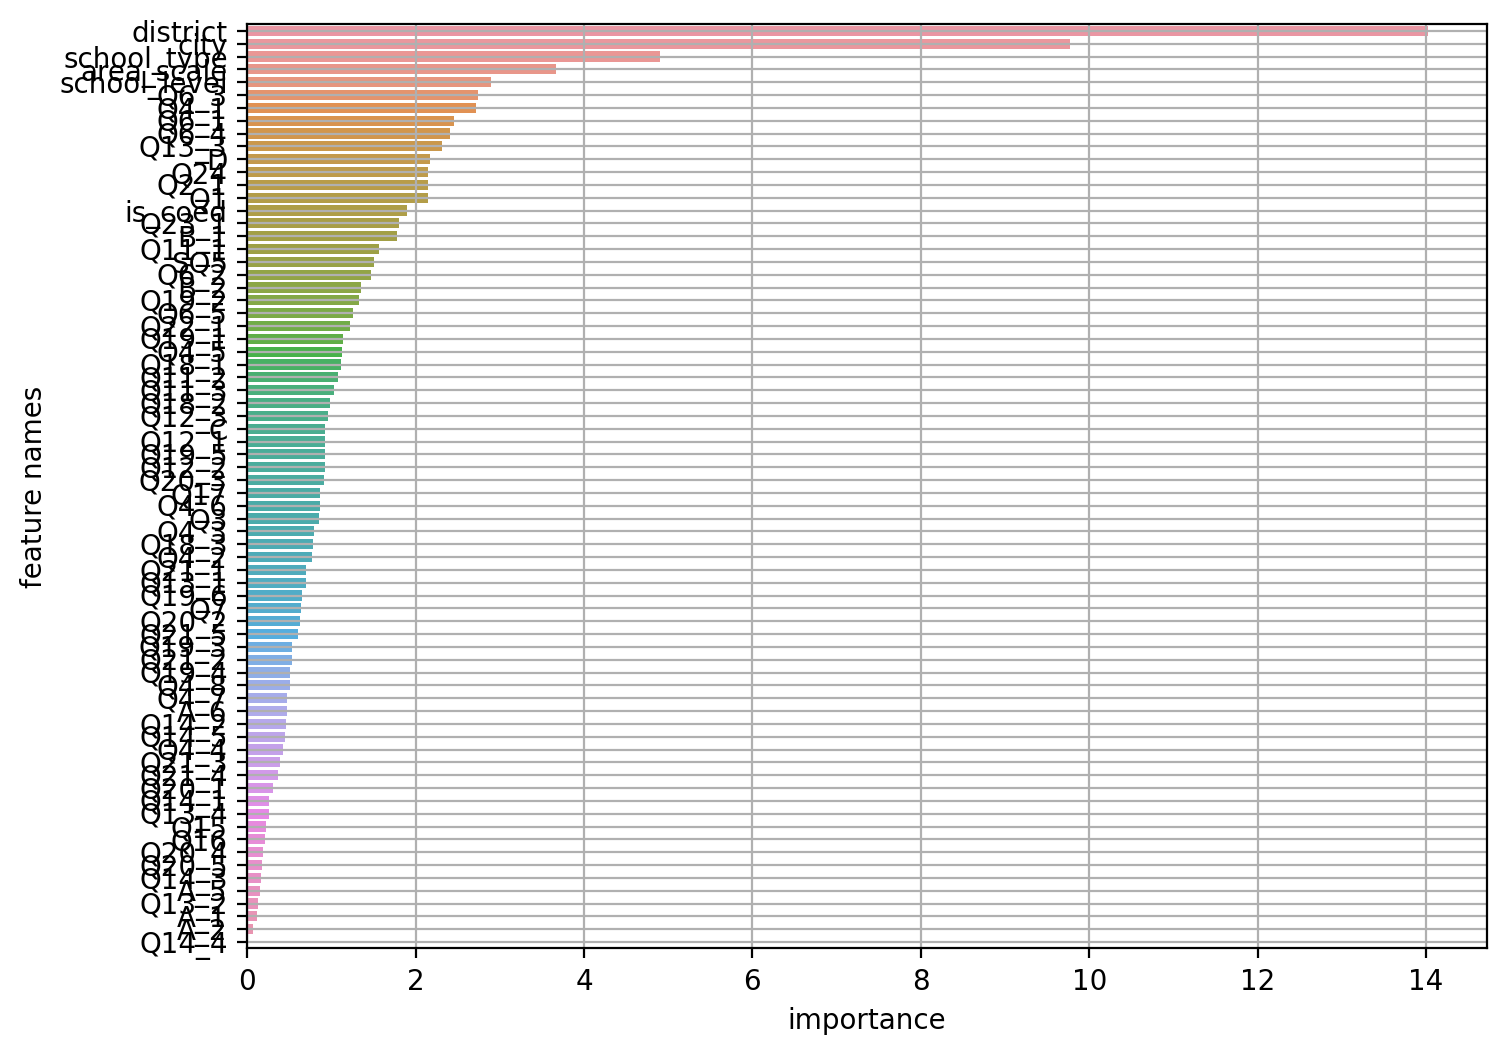

In [ ]:
result = plot_feature_importance(resampled_model.feature_importances_, list(x_train))

In [ ]:
# 성능테스트
y_pred = resampled_model.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1557
           1       0.58      0.23      0.33       247

    accuracy                           0.87      1804
   macro avg       0.73      0.60      0.63      1804
weighted avg       0.85      0.87      0.85      1804

[[1515   42]
 [ 190   57]]


In [ ]:
result

,feature_names,feature_importance
0,district,15.402436
1,city,12.771348
2,school_type,5.426907
3,area_scale,4.328839
4,Q24,3.602361
5,school_level,3.551783
6,Q2_1,2.611009
7,Q4_1,2.525831
8,Q23_1,2.443448
9,B_1,2.088506


In [ ]:
calculate_chi2(df_p, result)

,feature_name,chi2_val,p_value,dof,is_correlated
0,district,237.678718,1.838422e-09,122,x
1,city,49.028568,3.269965e-05,16,o
2,school_type,37.069679,2.557534e-05,9,o
3,area_scale,10.141511,1.740076e-02,3,o
4,Q24,15.620907,3.572411e-03,4,o
5,school_level,35.209903,2.260823e-08,2,o
6,Q2_1,22.390093,4.413259e-04,5,o
7,Q4_1,169.619862,1.537204e-36,3,o
8,Q23_1,31.536300,2.379385e-06,4,o
9,B_1,24.226429,1.039486e-03,7,o


# 5. 그냥 기존의 CatBoost(범주 재설정 x + 모든 변수를 범주화)로 REF 적용해보자 -> 가장 좋은 성능

In [ ]:
# train, test 분리 , 가변수화 안한 데이터 ->for catboost
df_b, X,y = preprocess(df)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1, stratify = y)
print(x_train.shape, x_test.shape)

(9017, 72) (9017,)
city ['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
district ['강남구' '강동구' '강릉시' '강북구' '강서구' '거제시' '거창군' '경산시' '경주시' '계룡시' '계양구' '고양시'
 '관악구' '광명시' '광산구' '광양시' '광주시' '광진구' '구로구' '구리시' '구미시' '군산시' '군포시' '금정구'
 '금천구' '기장군' '김천시' '김포시' '김해시' '나주시' '남구' '남동구' '남양주시' '남원시' '노원구' '논산시'
 '달서구' '달성군' '당진시' '대덕구' '도봉구' '동구' '동대문구' '동래구' '동작구' '동해시' '마포구' '목포시'
 '무안군' '미추홀구' '보령시' '보성군' '부산진구' '부안군' '부천시' '부평구' '북구' '사상구' '사천시' '사하구'
 '삼척시' '상주시' '서구' '서귀포시' '서대문구' '서초구' '성남시' '성동구' '성북구' '세종시' '속초시' '송파구'
 '수성구' '수영구' '수원시' '순천시' '아산시' '안동시' '안성시' '안양시' '양산시' '양천구' '양평군' '여수시'
 '연수구' '연제구' '영도구' '영주시' '예산군' '오산시' '완도군' '용인시' '울주군' '원주시' '유성구' '은평구'
 '음성군' '의정부시' '이천시' '익산시' '장수군' '전주시' '제주시' '제천시' '중구' '중랑구' '진주시' '진천군'
 '창녕군' '창원시' '천안시' '청주시' '춘천시' '충주시' '태안군' '통영시' '파주시' '평택시' '포항시' '하남시'
 '해운대구' '홍성군' '화성시']
school_level ['고등학교' '중학교' '초등학교']
school_type ['가사고등학교' '공업고등학교' '농림업고등학교' '상업고등학교' '실업고등학교' '외국어고등학교' '일반고등학교' '일반중학교'
 '종합고

In [ ]:
all_cols = list(x_train)
cat_model = CatBoostClassifier(cat_features = all_cols, auto_class_weights = 'Balanced', verbose=0, random_state = 1)
cat_model.fit(x_train, y_train)

In [ ]:
# 성능테스트
y_pred = cat_model.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

print("macro f1_score : ", f1_score(y_test,y_pred,average = 'macro'))
print("micro f1_score : ", f1_score(y_test,y_pred,average = 'micro'))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1557
           1       0.44      0.64      0.52       247

    accuracy                           0.84      1804
   macro avg       0.69      0.75      0.71      1804
weighted avg       0.87      0.84      0.85      1804

[[1355  202]
 [  90  157]]
macro f1_score :  0.7104416637533174
micro f1_score :  0.8381374722838137


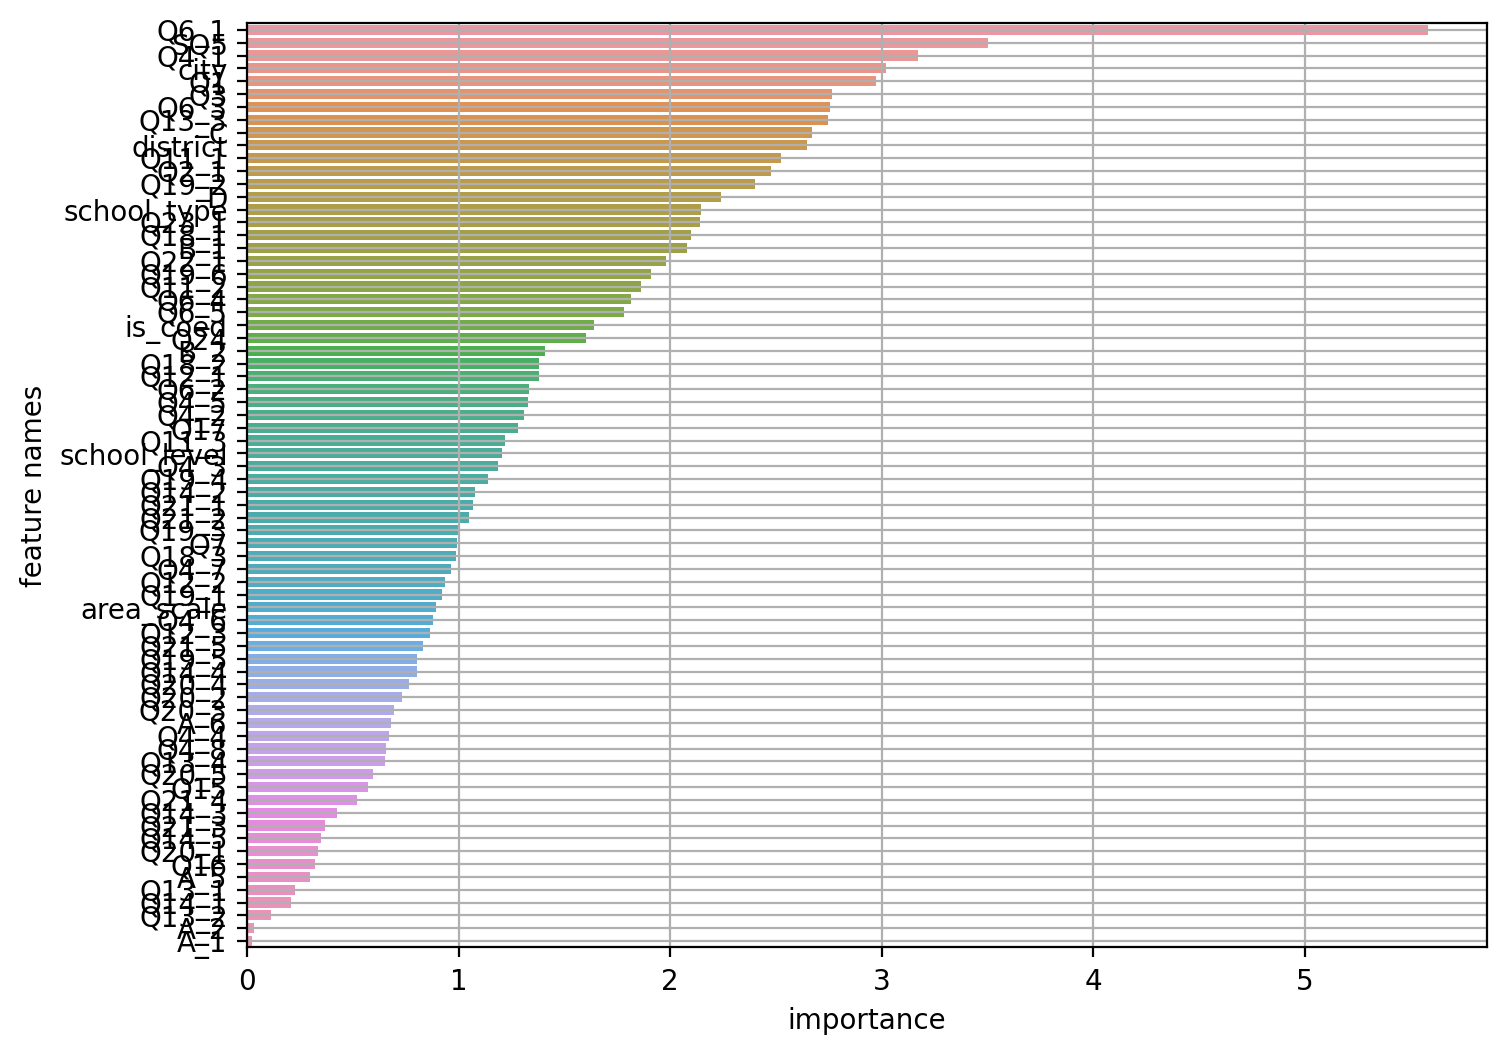

In [ ]:
result = plot_feature_importance(cat_model.feature_importances_, list(x_train))

In [ ]:
result

,feature_names,feature_importance
0,Q6_1,5.583996
1,SQ5,3.501462
2,Q4_1,3.169649
3,city,3.022046
4,Q1,2.973138
5,Q3,2.765474
6,Q6_3,2.756958
7,Q13_3,2.744753
8,C,2.672099
9,district,2.646131


In [ ]:
# x_train_z, x_val, y_train_z, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1, stratify = y_train)
# print(x_train_z.shape, x_val.shape, y_train_z.shape, y_val.shape)

In [ ]:
def select_features_catboost(algorithm, steps, num_to_select):
    
    model = CatBoostClassifier(iterations = 800, cat_features = all_cols, auto_class_weights = 'Balanced', verbose=0, random_state = 1)
    summary = model.select_features(X = x_train, y = y_train,
                                    features_for_select = list(range(x_train.shape[1])),
                                    num_features_to_select = num_to_select,
                                    steps = steps,
                                    algorithm = algorithm,
                                    shap_calc_type = 'Regular',
                                    train_final_model=True,
                                    plot = True,
                                    verbose = 50
                                    )
    y_pred = model.predict(x_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    return model,summary


In [ ]:
# ### 변수선택 based on ShapValues , step 7 - 상위 20개
# num_to_select = 60
# model_f_reduced, shap_summary = select_features_catboost('RecursiveByShapValues', 7, num_to_select)

In [ ]:
# selected_x = shap_summary['selected_features_names']
# selected_x

In [ ]:
#  변수 시각화
draw_stackedbar(df_p, result[:10])

KeyError: ignored

<Figure size 400x300 with 0 Axes>

In [ ]:
# 변수 확인
calculate_chi2(df_p, selected_x)

,feature_name,chi2_val,p_value,dof,is_correlated
0,city,49.028568,3.269965e-05,16,o
1,district,237.678718,1.838422e-09,122,x
2,school_level,35.209903,2.260823e-08,2,o
3,school_type,37.069679,2.557534e-05,9,o
4,is_coed,18.791721,8.306720e-05,2,o
5,area_scale,10.141511,1.740076e-02,3,o
6,SQ5,16.048877,6.172823e-05,1,o
7,Q1,28.771385,2.570907e-05,5,o
8,Q2_1,22.390093,4.413259e-04,5,o
9,Q3,33.738138,2.684567e-06,5,o


In [ ]:
shap_summary

{'selected_features': [0,
  3,
  7,
  8,
  9,
  10,
  18,
  19,
  20,
  21,
  22,
  46,
  49,
  50,
  61,
  62,
  63,
  68,
  70,
  71],
 'eliminated_features_names': ['A_1',
  'A_5',
  'A_2',
  'Q13_2',
  'Q14_3',
  'Q16',
  'Q14_1',
  'Q13_1',
  'Q15',
  'Q14_5',
  'Q14_4',
  'Q20_5',
  'Q21_3',
  'Q4_4',
  'Q13_4',
  'Q21_5',
  'Q14_2',
  'Q20_1',
  'A_6',
  'Q21_4',
  'Q21_2',
  'Q20_4',
  'Q4_8',
  'Q20_2',
  'Q21_1',
  'area_scale',
  'Q17',
  'Q19_4',
  'is_coed',
  'Q4_6',
  'Q12_1',
  'Q7',
  'Q12_3',
  'Q19_1',
  'Q4_2',
  'Q18_1',
  'Q12_2',
  'Q11_3',
  'Q4_5',
  'Q4_7',
  'SQ5',
  'B_2',
  'school_level',
  'Q18_2',
  'Q20_3',
  'Q13_3',
  'Q18_3',
  'Q19_3',
  'Q4_3',
  'Q11_2',
  'Q11_1',
  'district'],
 'loss_graph': {'main_indices': [0, 12, 22, 30, 37, 43, 48, 52],
  'removed_features_count': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
  

In [ ]:
# num_to_select = 10
# model_step7_2, shap_step7_summary_2 = select_features_catboost('RecursiveByShapValues', 7, num_to_select)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.076907
Step #1 out of 7
0:	learn: 0.6837338	test: 0.6854671	best: 0.6854671 (0)	total: 255ms	remaining: 1m 41s
50:	learn: 0.5718872	test: 0.6079902	best: 0.6079902 (50)	total: 6.19s	remaining: 42.3s
100:	learn: 0.5279306	test: 0.5924802	best: 0.5923679 (97)	total: 12.1s	remaining: 35.9s
150:	learn: 0.4645468	test: 0.5750538	best: 0.5749398 (149)	total: 20.8s	remaining: 34.3s
200:	learn: 0.4166919	test: 0.5604084	best: 0.5603429 (199)	total: 27.5s	remaining: 27.2s
250:	learn: 0.3771065	test: 0.5579955	best: 0.5562094 (244)	total: 33.8s	remaining: 20s
300:	learn: 0.3407488	test: 0.5522216	best: 0.5501143 (291)	total: 39.3s	remaining: 12.9s
350:	learn: 0.3088560	test: 0.5552384	best: 0.5501143 (291)	total: 47.2s	remaining: 6.58s
399:	learn: 0.2872001	test: 0.5557853	best: 0.5501143 (291)	total: 52.5s	remaining: 0us

bestTest = 0.5501143159
bestIteration = 291

Shrink model to first 292 iterations.
Feature #41 eliminated
Feature #1 eliminated
Feature #67 eliminated
F

[[1147  410]
 [  80  167]]
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1557
           1       0.29      0.68      0.41       247

    accuracy                           0.73      1804
   macro avg       0.61      0.71      0.61      1804
weighted avg       0.85      0.73      0.77      1804



In [ ]:
selected_x_2 = shap_step7_summary_2['selected_features_names']
selected_x_2

NameError: ignored

<Figure size 400x300 with 0 Axes>

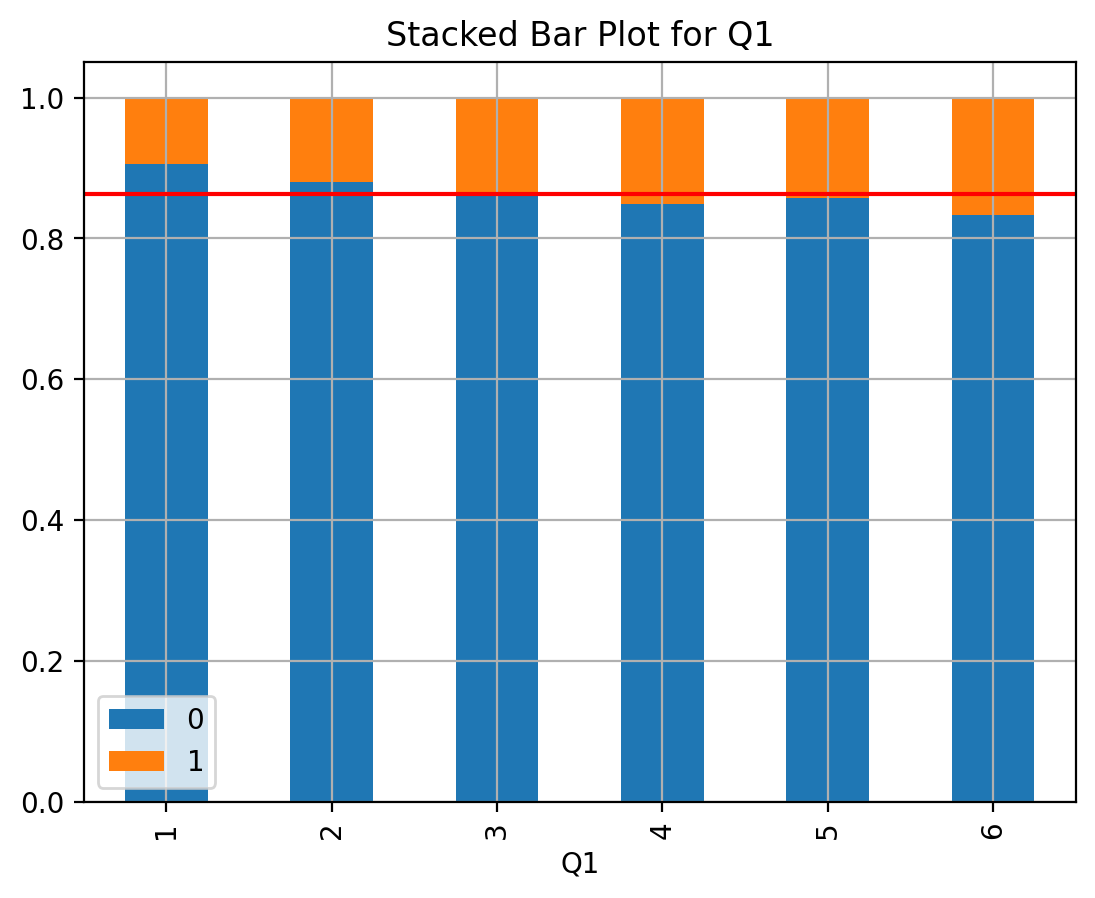

<Figure size 400x300 with 0 Axes>

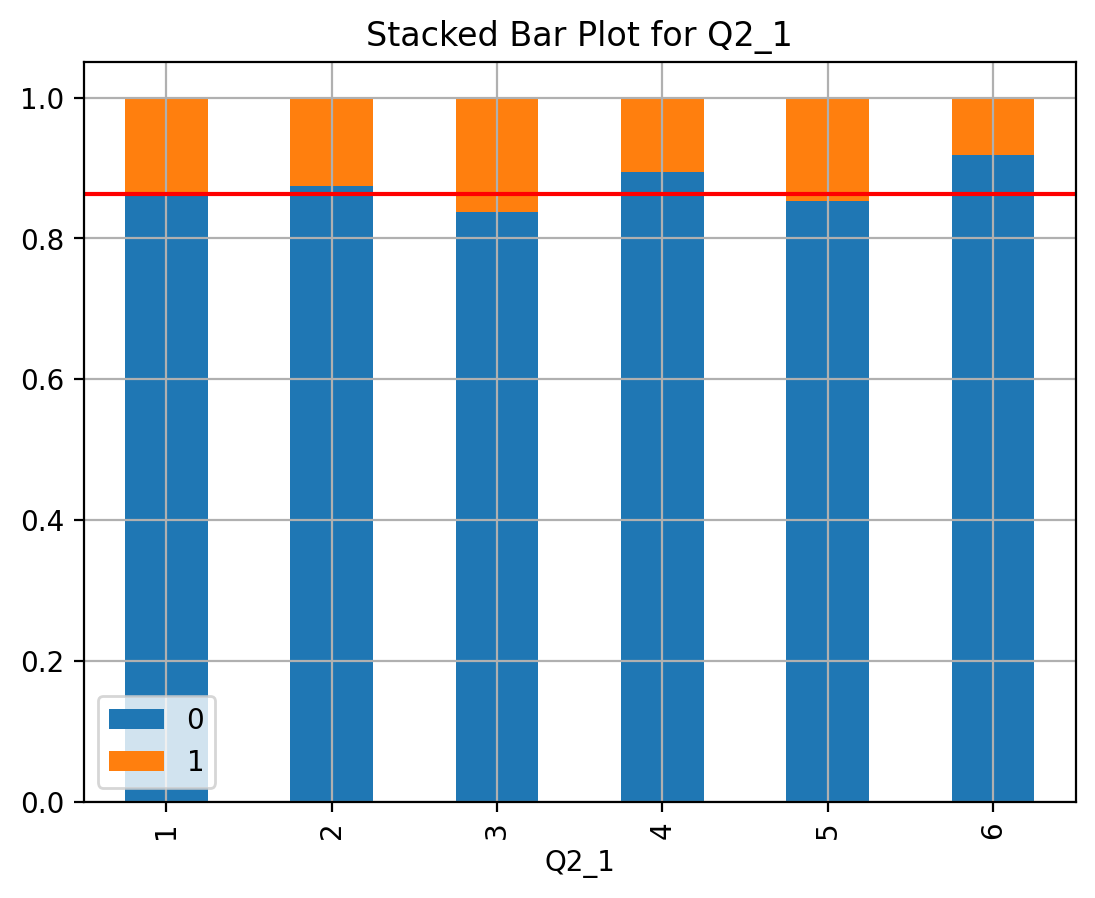

<Figure size 400x300 with 0 Axes>

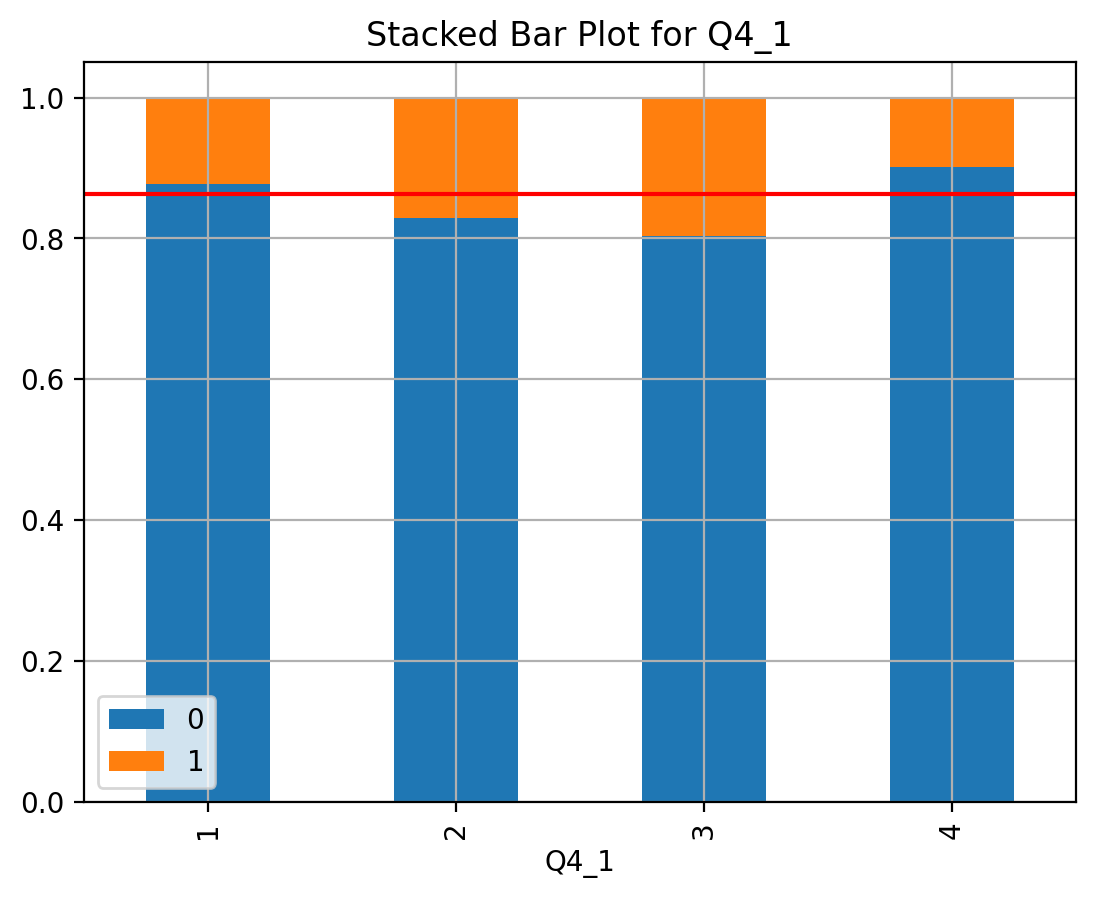

<Figure size 400x300 with 0 Axes>

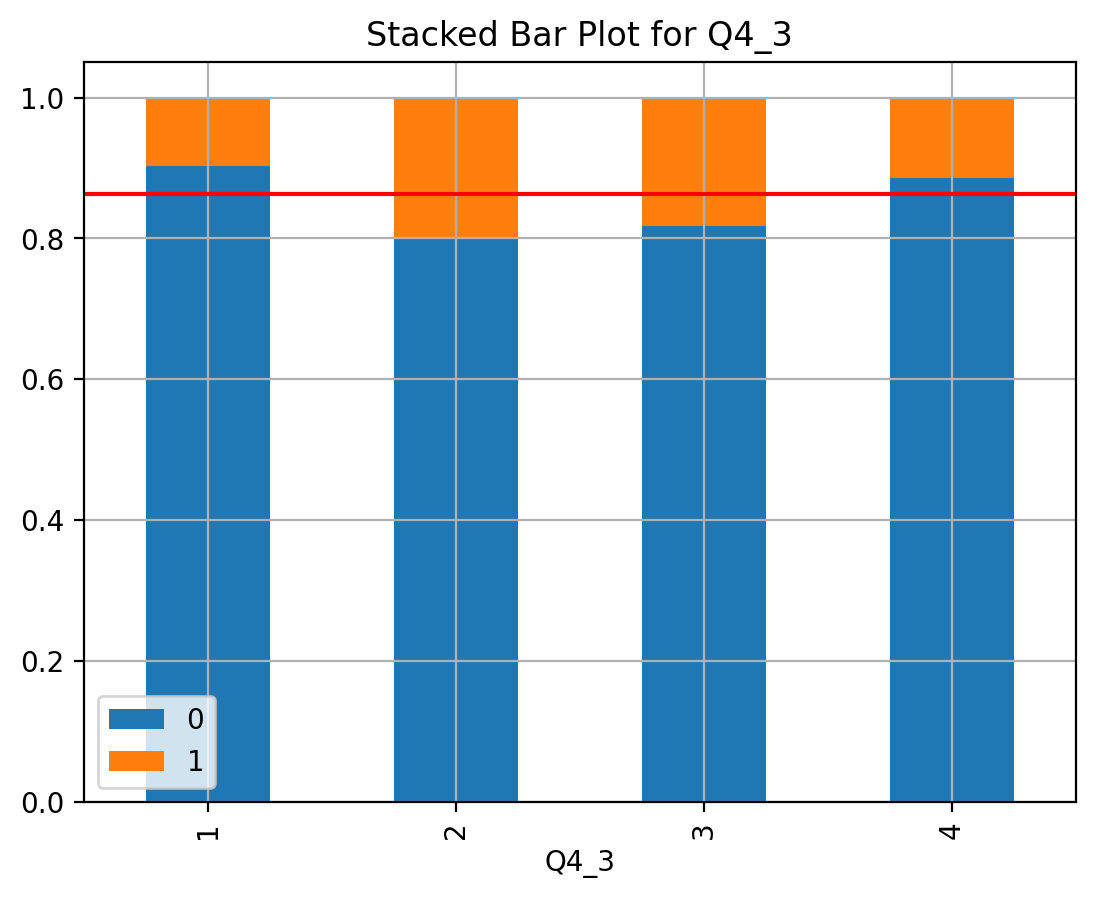

<Figure size 400x300 with 0 Axes>

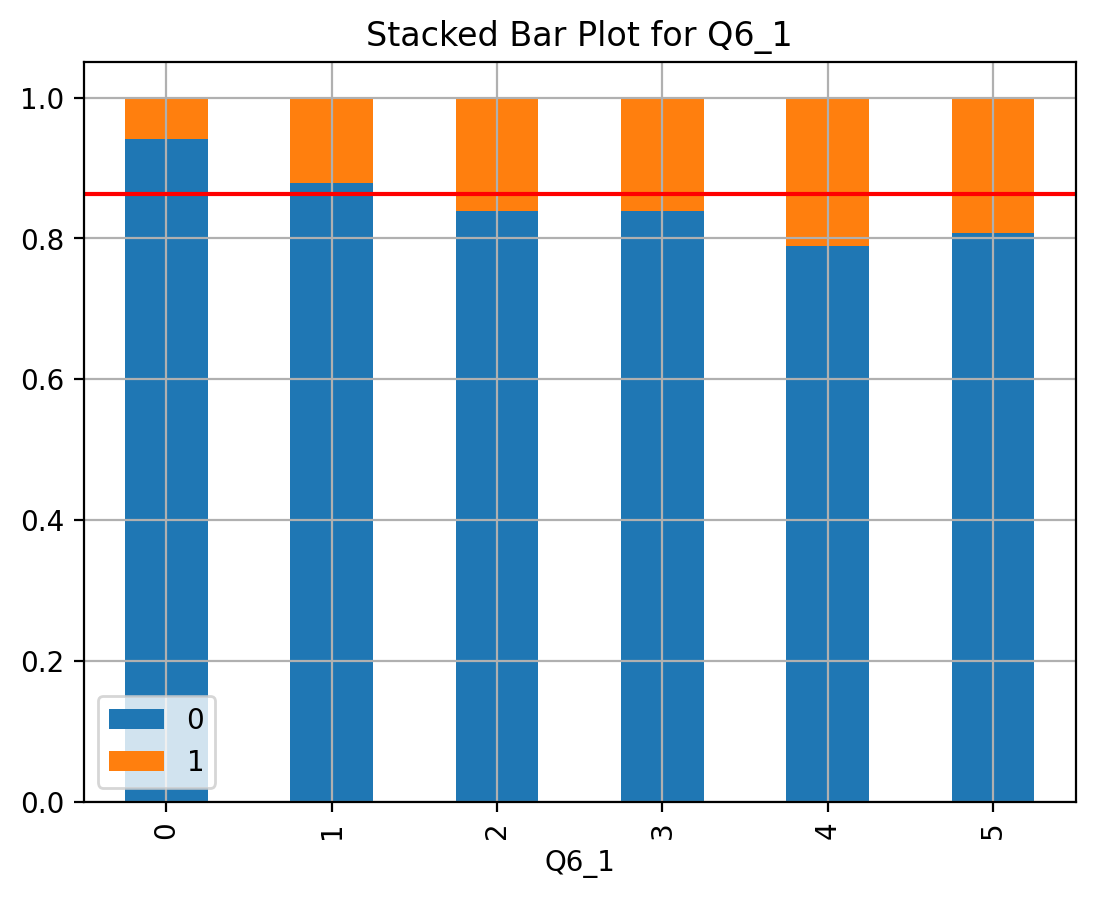

<Figure size 400x300 with 0 Axes>

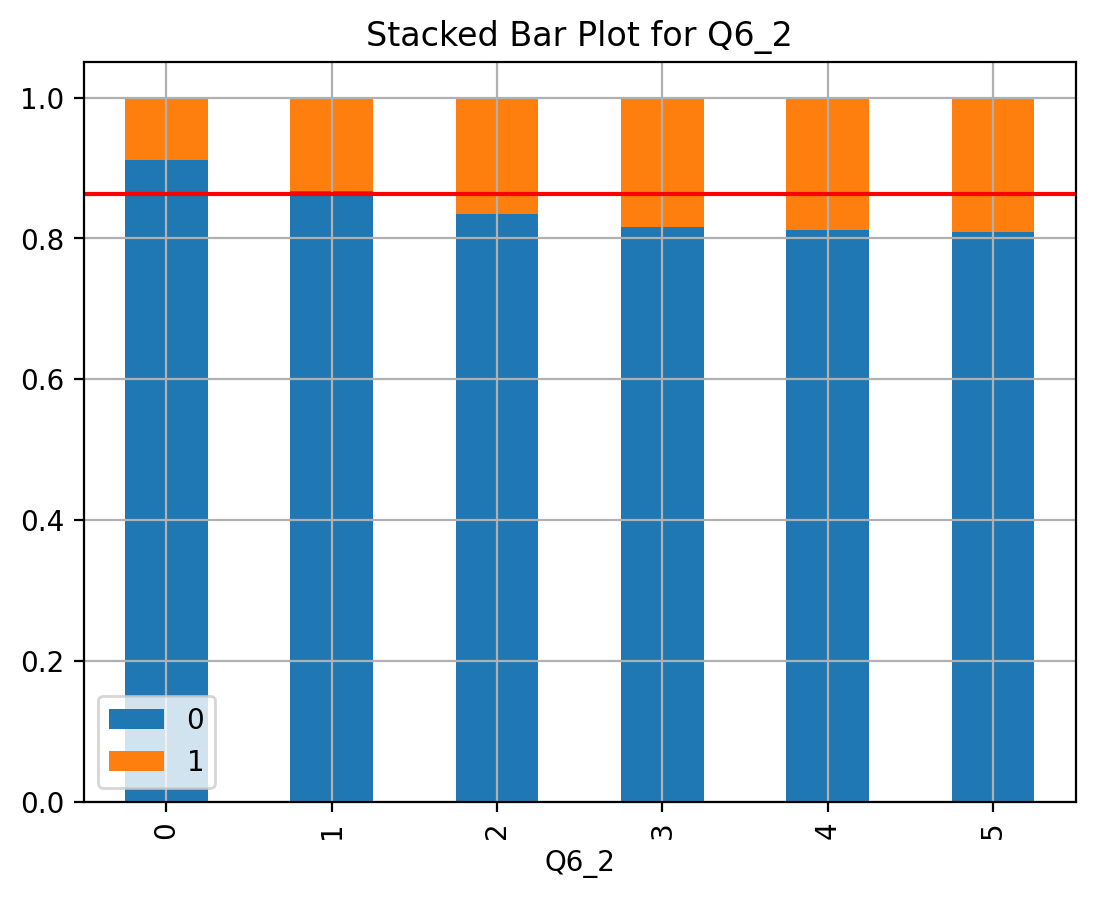

<Figure size 400x300 with 0 Axes>

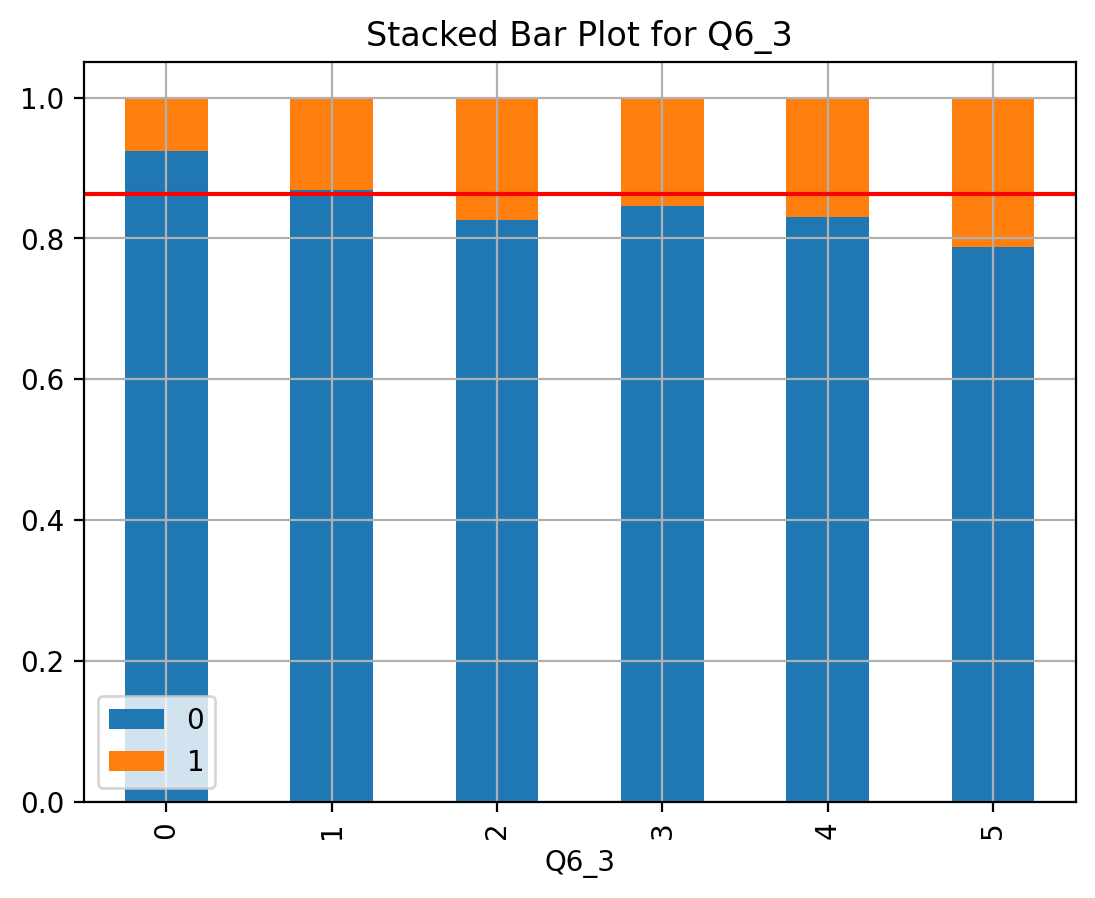

<Figure size 400x300 with 0 Axes>

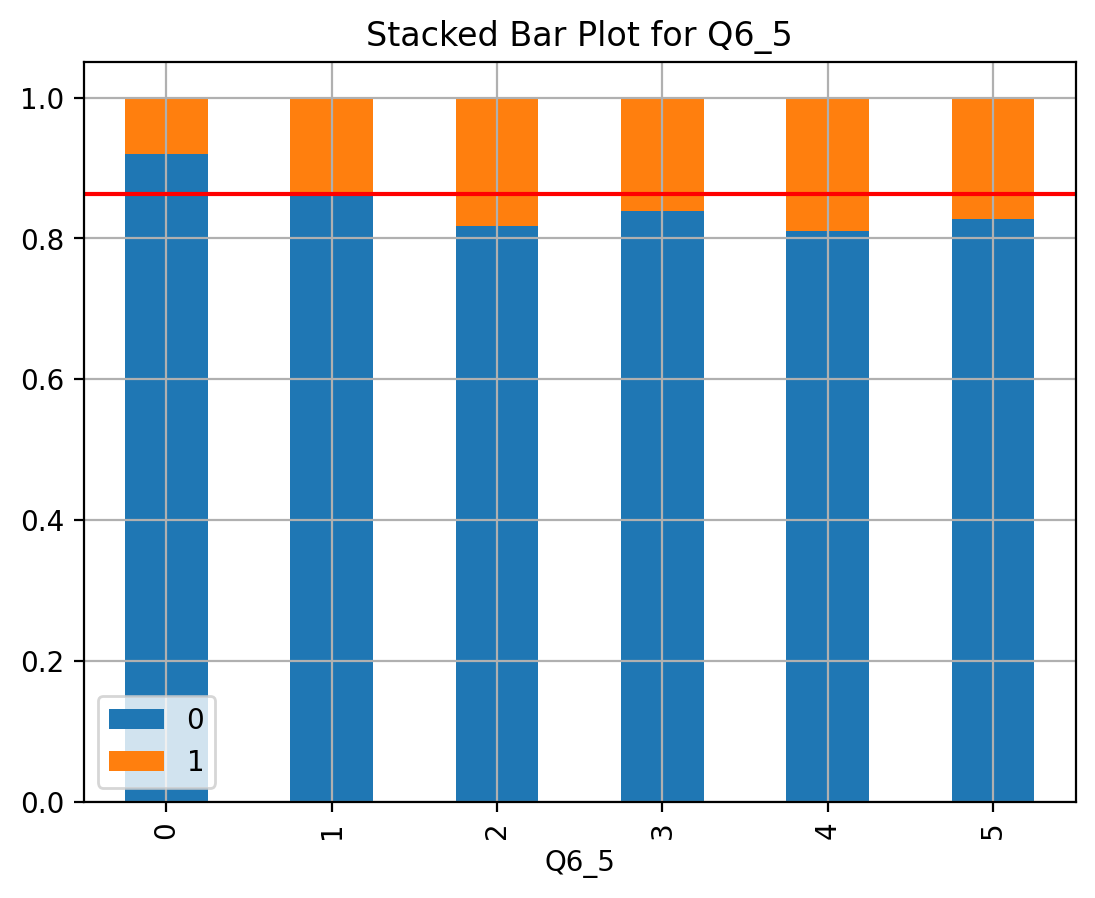

<Figure size 400x300 with 0 Axes>

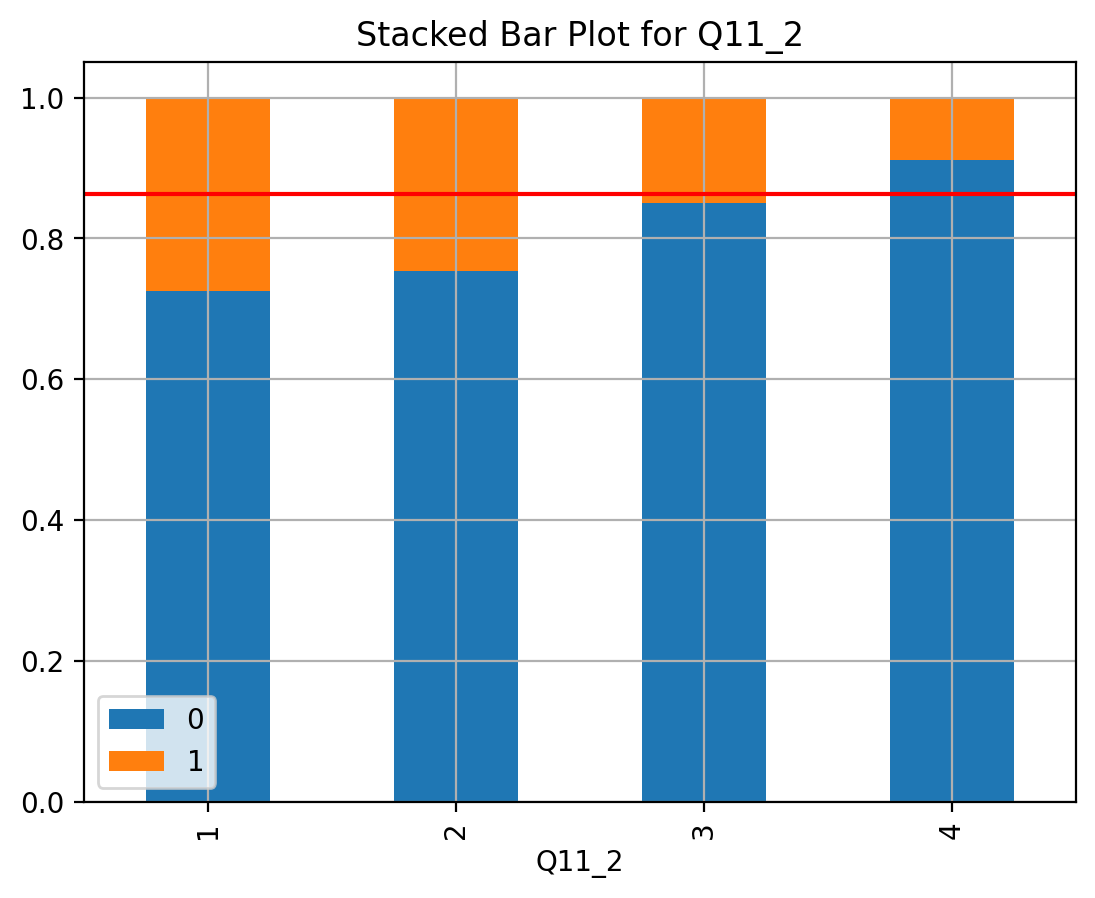

<Figure size 400x300 with 0 Axes>

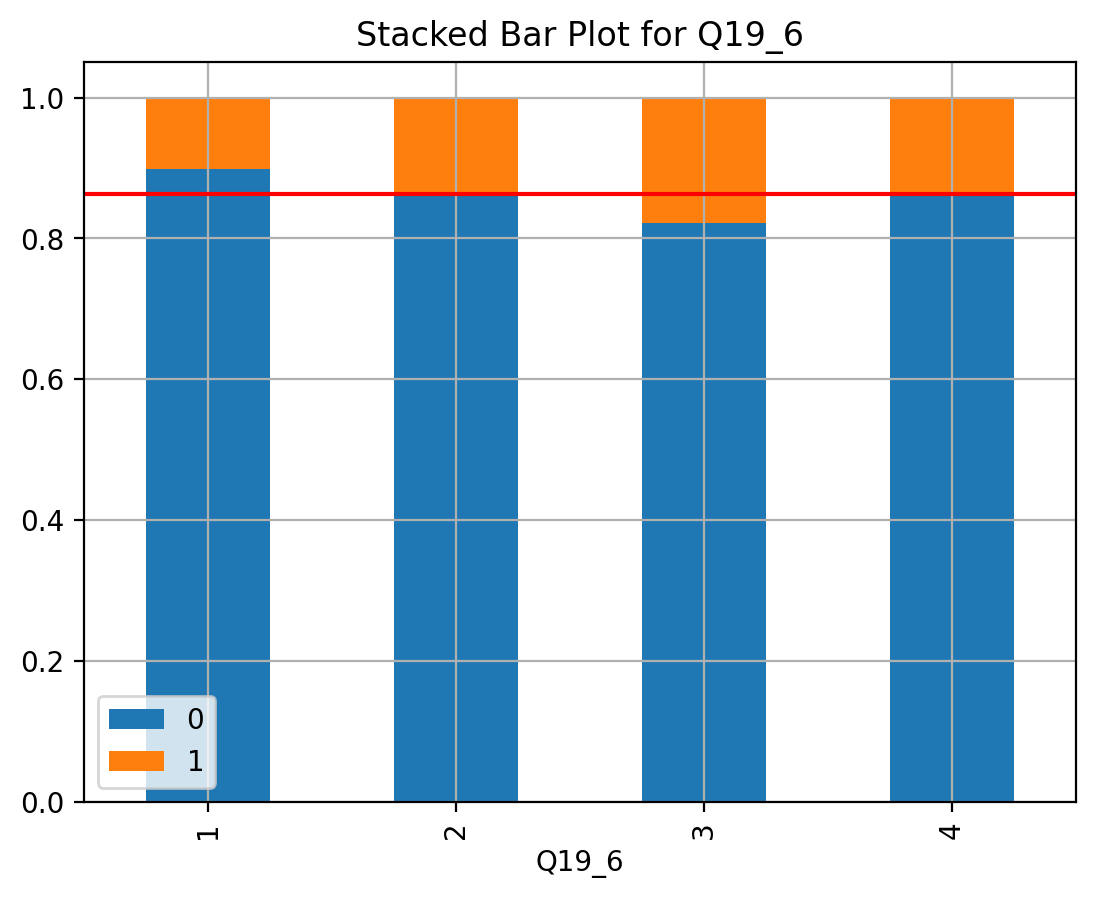

In [ ]:
lst = ['Q1',
 'Q2_1',
 'Q4_1',
 'Q4_3',
 'Q6_1',
 'Q6_2',
 'Q6_3',
 'Q6_5',
 'Q11_2',
 'Q19_6']
draw_stackedbar(df_p, lst)

## shap으로 다시 확인

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 39.5 MB/s eta 0:00:00


In [ ]:
# shap 함수 생성
import tensorflow as tf
import shap
tf.compat.v1.disable_v2_behavior() # shap 그래프가 tf1 버전을 지원합니다. tf2는 비활성화.

def show_shap(model_cat, x_train_b):

    # 1. Shapley Value 만들기

    # SHAP 값으로 모델의 예측 설명하기
    explainer1 = shap.TreeExplainer(model_cat, output_names=['offence_False', 'offence_True'])    #  선언
    shap_values1 = explainer1.shap_values(x_train_b)    # value 뽑기
    print(x_train_b.shape, shap_values1.shape)

    shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함. jupyter는 한 번만 해도 ok


    # 2. 전체 변수에 대한 shap value 시각화

    shap_values1 = explainer1.shap_values(x_train_b)

    # SHAP 요약도(SHAP Summary Plot) 20위
    shap.summary_plot(shap_values1, x_train_b, show=False)
    
    # SHAP 요약도(SHAP Summary Plot)
    shap.summary_plot(shap_values1, x_train_b, show=False, max_display=len(x_train_b.columns))



    # # 3. 특정 관점으로 Data point이 Shap Value 정렬

    # force_plot = shap.force_plot(explainer1.expected_value, shap_values1, x_train_b)
    # display(force_plot)

    # # HTML 파일로 저장
    # shap.save_html(path + '/shap/' + folder +'/force_plot.html', force_plot)


    # # 4. 특정 변수 값과 변수의 shap value 간의 관계

    # for col in x_train_b:
    #     # SHAP 의존도(SHAP Dependency Plot)
    #     shap.dependence_plot(col, shap_values1, x_train_b, interaction_index=None, show=False)
        
    #     # SHAP 상호작용값(SHAP Interactive Values)
    #     shap.dependence_plot(col, shap_values1, x_train_b, show=False)
       

Instructions for updating:
non-resource variables are not supported in the long term


(7213, 72) (7213, 72)


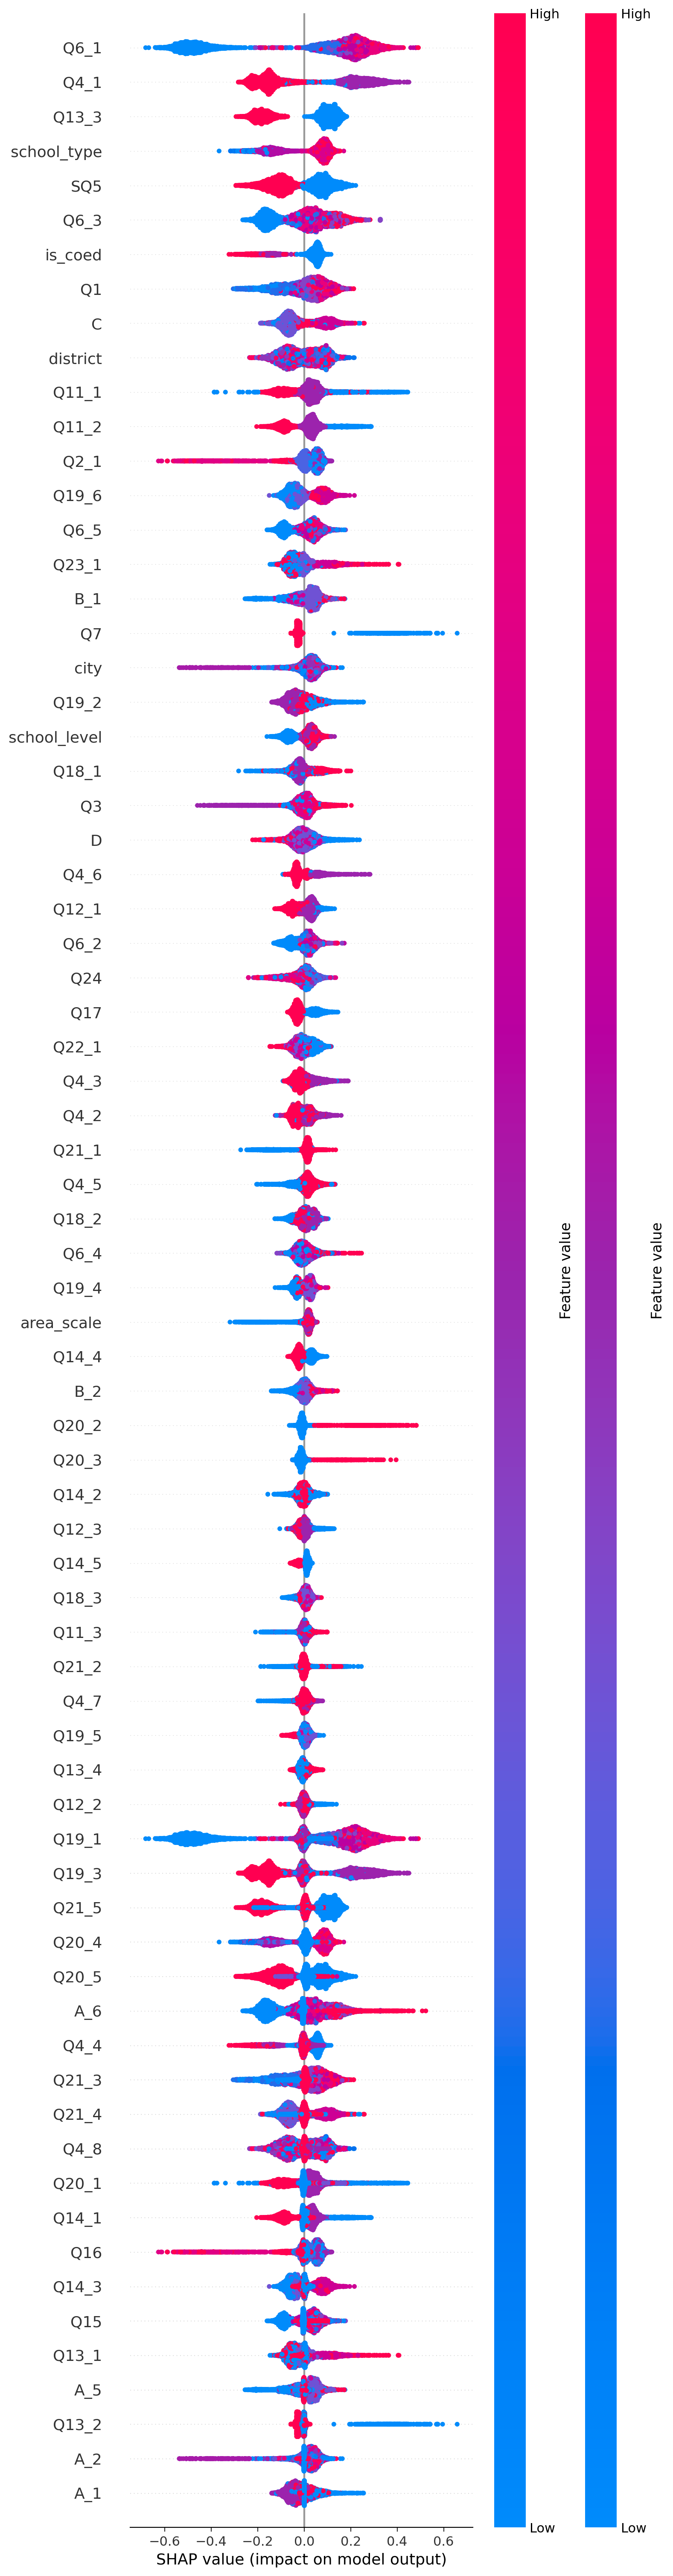

In [ ]:
show_shap(cat_model, x_train)

# 6. 전처리 통합 된 버전으로 CatBoost 돌려보기

In [ ]:
df_p,X,y = preprocess_reset_category(df)

(9017, 72) (9017,)


In [ ]:
X.head(2)

,city,district,school_level,school_type,is_coed,area_scale,SQ5,Q1,Q2_1,Q3,Q4_1,Q4_2,Q4_3,Q4_4,Q4_5,Q4_6,Q4_7,Q4_8,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q7,Q11_1,Q11_2,Q11_3,Q12_1,Q12_2,Q12_3,Q13_1,Q13_2,Q13_3,Q13_4,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q15,Q16,Q17,Q18_1,Q18_2,Q18_3,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q22_1,Q23_1,Q24,A_1,A_2,A_5,A_6,B_1,B_2,C,D
0,8,46,2,9,0,3,1,3,1,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,3,4,1,2,3,4,5,1,2,2,2,2,1,2,2,2,2,2,2,0,0,2,0,0,2,2,2,2,2,1,1,5,1,2,5,0,5,5,5,4
1,8,46,2,9,0,3,2,3,5,1,2,2,2,2,2,2,2,2,0,0,0,0,0,2,2,2,2,2,2,2,1,0,0,0,1,0,0,4,0,1,2,2,2,2,2,2,2,2,1,1,1,0,0,0,0,0,2,2,2,2,2,2,1,4,0,0,0,0,5,5,4,5


In [ ]:
# train, test 분리 , 가변수화 안한 데이터 ->for catboost
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1, stratify = y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7213, 72) (1804, 72) (7213,) (1804,)


In [ ]:
norminal_cols = ['city', 'district', 'school_level', 'school_type', 'is_coed', 'area_scale', 'SQ5', 'Q2_1' ,'Q7',  'Q13_1',
                 'Q13_2', 'Q13_3', 'Q13_4', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q15', 'Q16', 'Q17', 'Q22_1', 
                 'Q23_1', 'Q24',  'A_1', 'A_2', 'A_5', 'A_6', 'B_1', 'B_2']

In [ ]:
from imblearn.over_sampling import SMOTENC, SMOTE
norminal_indices = [X.columns.get_loc(col) for col in norminal_cols]

smote = SMOTENC(categorical_features= norminal_indices,sampling_strategy='auto')   #categorical_features에는 열 인덱스 명시해줘야함
x_smote, y_smote = smote.fit_resample(x_train, y_train)
x_smote.shape, y_smote.shape

((12448, 72), (12448,))

In [ ]:
# # train, test 분리
# x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(x_smote ,y_smote,test_size=0.2,random_state=1, stratify = y_smote)

# print(x_train_b.shape, y_train_b.shape, x_test_b.shape, y_test_b.shape)

In [ ]:
# 모델링
resampled_model = CatBoostClassifier(cat_features = norminal_cols, verbose = 0) # 명목형 범주형변수로 간주
resampled_model.fit(x_smote, y_smote)

In [ ]:
# 성능테스트
y_pred = resampled_model.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1557
           1       0.40      0.22      0.28       247

    accuracy                           0.85      1804
   macro avg       0.64      0.58      0.60      1804
weighted avg       0.82      0.85      0.83      1804

[[1477   80]
 [ 193   54]]


In [ ]:
resampled_model_allcols = CatBoostClassifier(cat_features = all_cols, verbose = 0) # 전체를 범주형변수로 간주
resampled_model_allcols.fit(x_train_b, y_train_b)

In [ ]:
# 성능테스트
y_pred = resampled_model_allcols.predict(x_test_b)
print(classification_report(y_test_b,y_pred))
print(confusion_matrix(y_test_b,y_pred))

In [ ]:
result = plot_feature_importance(resampled_model.feature_importances_, list(x_train_b))

# 7. Optuna + catboost 하이퍼파라미터 튜닝
- reference : https://dacon.io/en/competitions/official/235848/codeshare/4040 , 원영님

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
# train, test 분리 , 가변수화 안한 데이터 ->for catboost
df_b, X,y = preprocess(df)

x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=1, stratify = y)
x_val, x_test, y_val, y_test = train_test_split(x_val,y_val, test_size = 0.5, random_state = 1, stratify= y_val)
print(x_train.shape,x_val.shape, x_test.shape,)

(9017, 70) (9017,)
(6311, 70) (1353, 70) (1353, 70)


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import *
all_cols = list(X)
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('deptSh', 7, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
    }
    
    clf = CatBoostClassifier(**params, cat_features = all_cols, auto_class_weights = 'Balanced', verbose=0, random_state = 1)
    clf.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=50, verbose=False)
    y_pred = clf.predict(x_test)
    f1 = f1_score(y_test, y_pred,average = 'macro')
    
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-04-29 03:29:53,387] A new study created in memory with name: no-name-bff778cc-5dc1-4251-9298-dbb91f39f788
[I 2023-04-29 03:29:55,460] Trial 0 finished with value: 0.6074327262082593 and parameters: {'learning_rate': 0.042274765169223766, 'depth': 10, 'l2_leaf_reg': 0.03886778264876347, 'colsample_bylevel': 0.041015925216538886}. Best is trial 0 with value: 0.6074327262082593.
[I 2023-04-29 03:29:58,235] Trial 1 finished with value: 0.6354542713946565 and parameters: {'learning_rate': 0.06471369585944141, 'depth': 10, 'l2_leaf_reg': 0.018316423164885996, 'colsample_bylevel': 0.05106189935877642}. Best is trial 1 with value: 0.6354542713946565.
[I 2023-04-29 03:30:02,193] Trial 2 finished with value: 0.5839736622651874 and parameters: {'learning_rate': 0.09841245747585037, 'depth': 9, 'l2_leaf_reg': 0.0010781330217434833, 'colsample_bylevel': 0.08498248474399962}. Best is trial 1 with value: 0.6354542713946565.
[I 2023-04-29 03:30:03,753] Trial 3 finished with value: 0.6406652557

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7341353130182422
  Params: 
    learning_rate: 0.02144374729461743
    depth: 12
    l2_leaf_reg: 3.5272777664980843
    colsample_bylevel: 0.01708455842684544


In [ ]:
best_params = {
    'learning_rate': 0.02144374729461743,
    'depth': 12,
    'l2_leaf_reg': 3.5272777664980843,
    'colsample_bylevel': 0.01708455842684544
}

best_model = CatBoostClassifier(**best_params, cat_features = all_cols,
                                auto_class_weights = 'Balanced', verbose=0, random_state = 1)
best_model.fit(x_train, y_train)


In [ ]:
# Best_model 성능테스트
y_pred = best_model.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(f1_score(y_test, y_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1168
           1       0.81      0.32      0.46       185

    accuracy                           0.90      1353
   macro avg       0.85      0.65      0.70      1353
weighted avg       0.89      0.90      0.88      1353

[[1154   14]
 [ 126   59]]
0.8965262379896525
